In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.trials.spikes import firing_rate,sp_constants
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.structures.trials_data import TrialsData
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.task import task_constants
import os 

### Load file

In [2]:
filepath = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/lip/2022-11-30_10-42-03_Riesling_lip_e1_r1.h5"
s_path = os.path.normpath(filepath).split(os.sep)
data = TrialsData.from_python_hdf5(filepath)

### Select relevant trials

In [3]:
# Select trials and create task frame
trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 2))[0]
cgroup = "good"
neurons = np.where(data.clustersgroup == cgroup)[0]
print("Number of clusters: %d" % len(data.clustersgroup))
print("Number of %s units: %d" % (cgroup, len(neurons)))


Number of clusters: 10
Number of good units: 7


### Select trials by target code

In [5]:
# Define target codes 
target_codes= {
    # code: [ML axis], [plot axis]
    '127': [[10,0],[1,2]],
    '126': [[7,7],[0,2]],
    '125': [[0,10],[0,1]],
    '124': [[-7,7],[0,0]],
    '123': [[-10,0],[1,0]],
    '122': [[-7,-7],[2,0]],
    '121': [[0,-10],[2,1]],
    '120': [[7,-7],[2,2]],
}

In [6]:
# create dict with the trials that have each code
trials_idx = {}
for i_key,key in enumerate(target_codes.keys()):
    trials = []
    code_idx=[]
    for i_trial,code in zip(trial_idx, data.code_numbers[trial_idx]):
        idx=np.where(int(key) == code)[0]
        if len(idx)!=0:
            code_idx.append(idx[0])
            trials.append(i_trial)
    trials_idx[key]={'code_idx':code_idx,'trials_idx':trials}

## Plot rasters for each neuron for each target

#### define variables

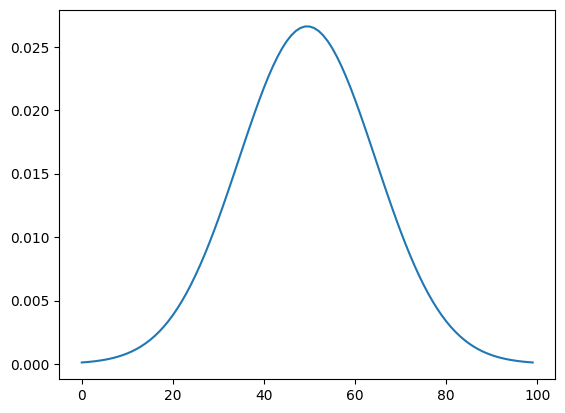

In [7]:
fs_ds = config.FS / config.DOWNSAMPLE
kernel = firing_rate.define_kernel(
    sp_constants.W_SIZE, sp_constants.W_STD, fs=fs_ds
)
plt.plot(kernel)

#### Plot all trials with the same code for all neurons 

##### Split in stimulus presentation delay and saccade
Compute:
* visual pref / visual unpref -> target_on(37) - target_off(38)
* delay pref / delay unpref -> target_off(38) - fix_spot_off(36)
* saccade pref / saccade unpref -> fix_spot_off(10) - correct_response(40)

/tmp/ipykernel_58527/2555852708.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot2grid((3, 3), (axis[0], axis[1]))
/tmp/ipykernel_58527/2555852708.py:33: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(
/tmp/ipykernel_58527/2555852708.py:18: RuntimeWarning: Mean of empty slice.
  mean_sp = shift_sp.mean(axis=0)
/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


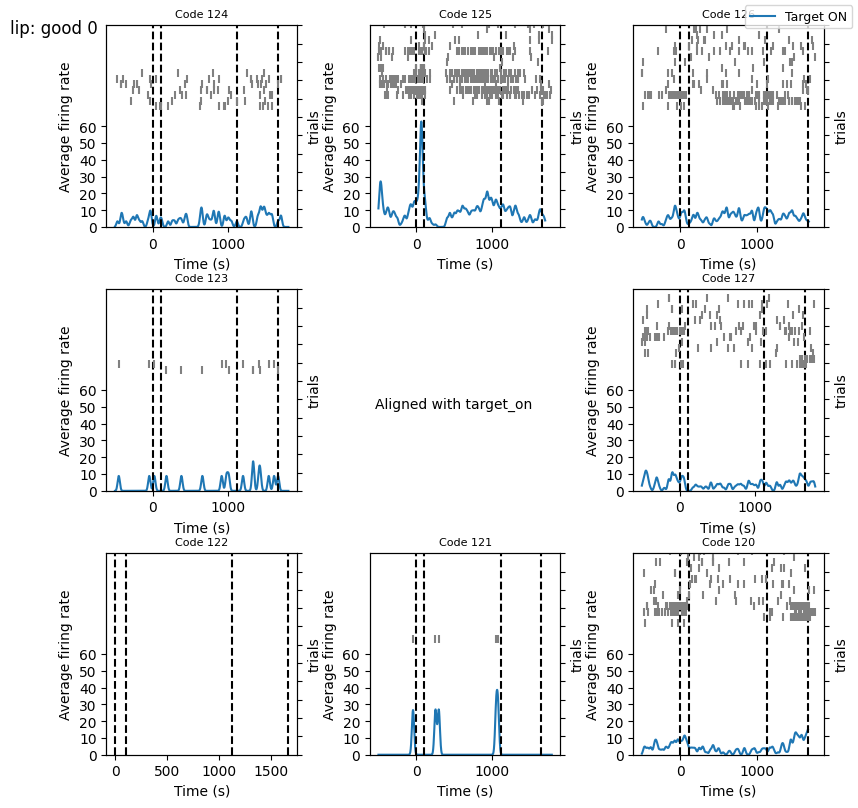

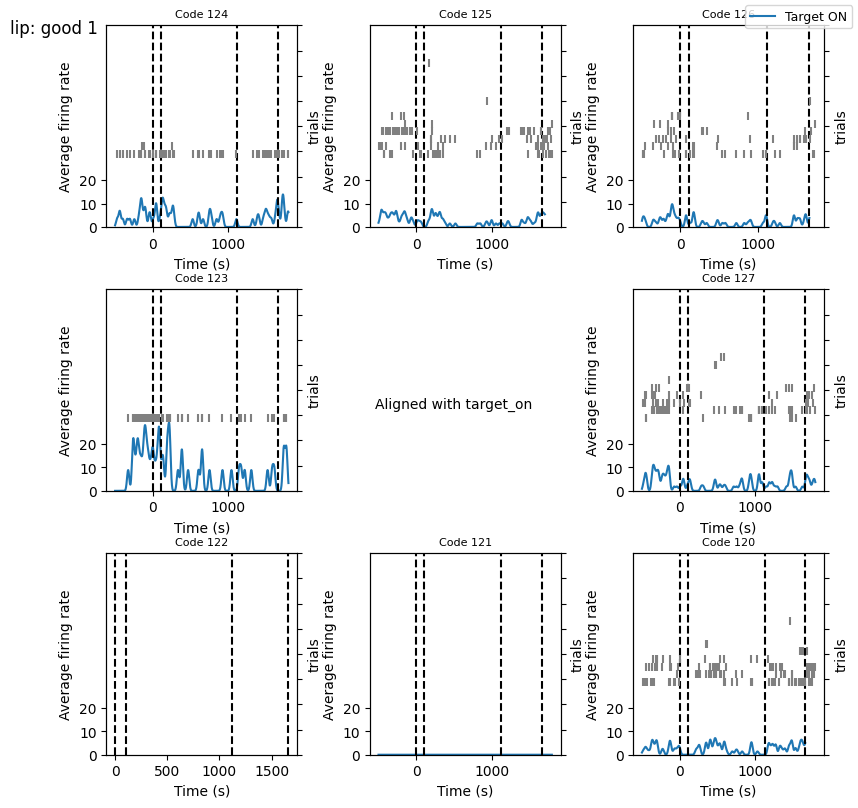

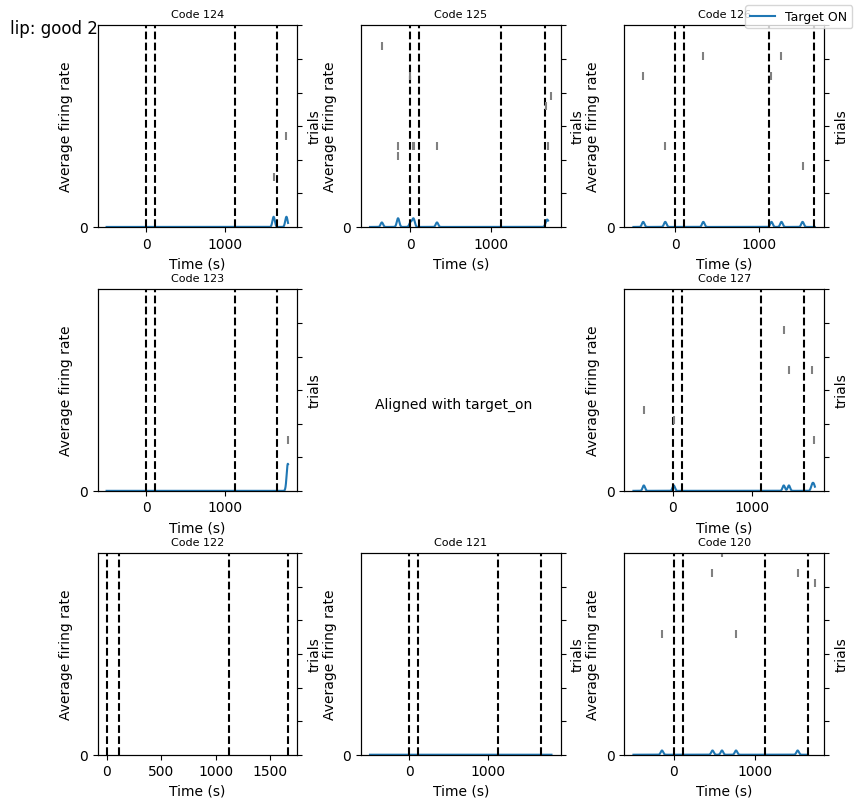

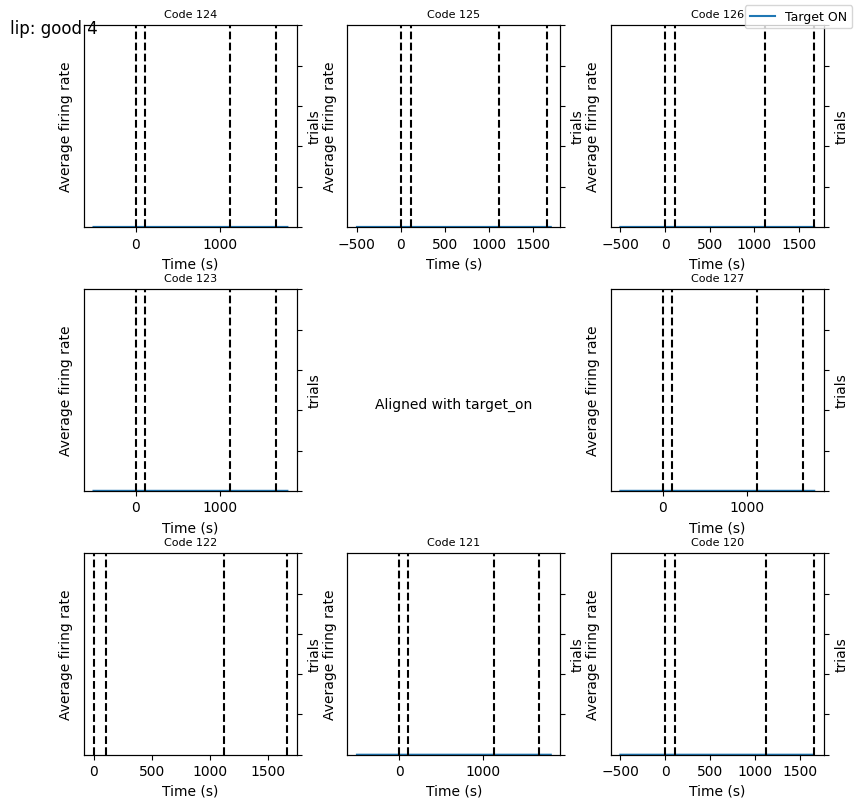

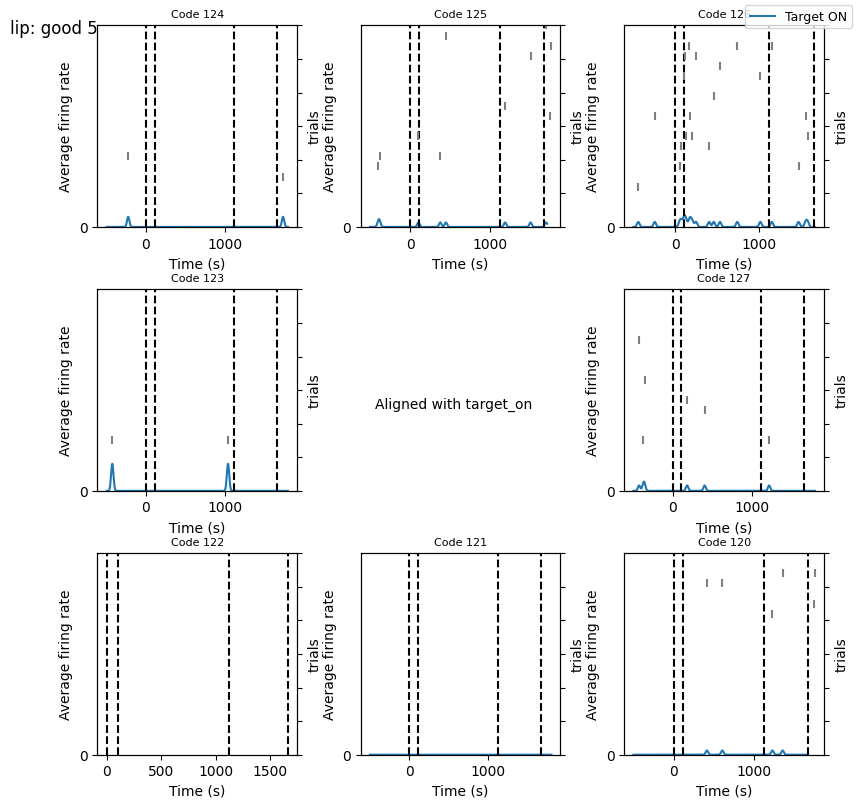

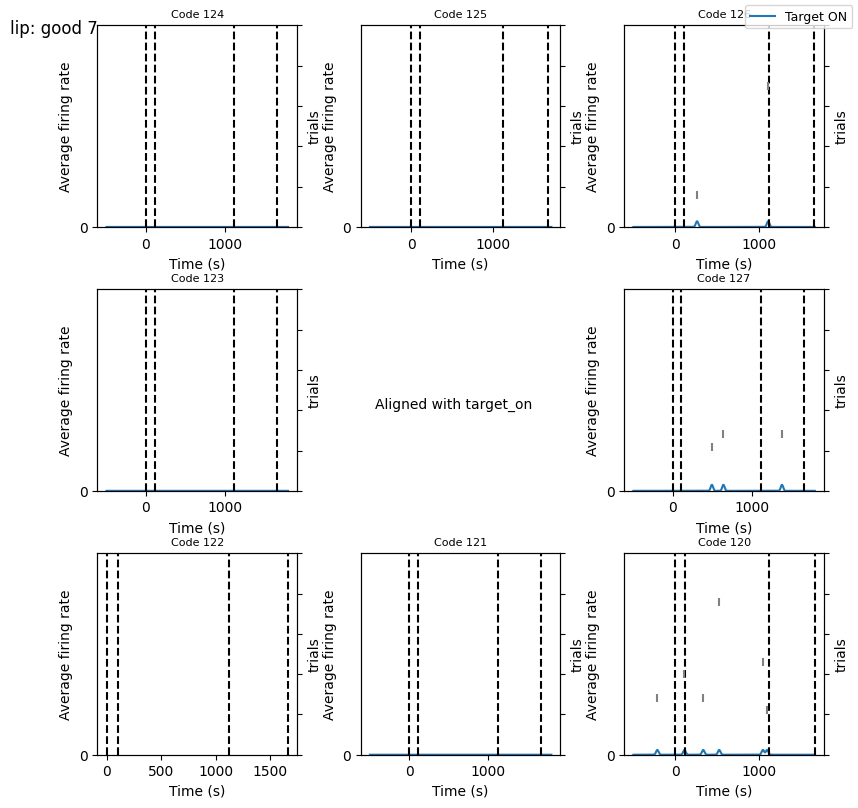

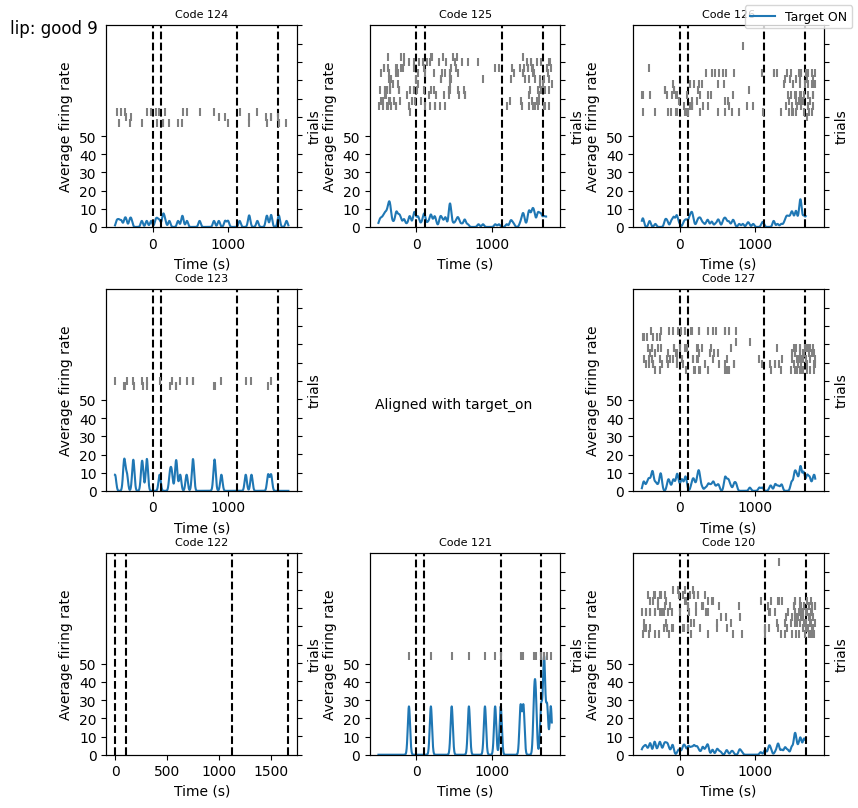

In [9]:
# plots x lim
e_align = "target_on"
t_before = 500
# select only individual neurons
for i,neuron in enumerate(neurons):
    fig,_ = plt.subplots(figsize=(8, 8),sharex=True,sharey=True)
    all_ax,all_ax2 = [],[]
    all_max_conv,max_num_trials = 0,0
    for code in target_codes.keys():
        target_t_idx = trials_idx[code]["trials_idx"] # select trials with the same stimulus
        trials_s_on = data.code_samples[
            target_t_idx,
            np.where(data.code_numbers[target_t_idx] == task_constants.EVENTS_B2[e_align])[
                1
            ],
        ]
        shift_sp = TrialsData.indep_roll(data.sp_samples[target_t_idx,neuron], -(trials_s_on - t_before).astype(int), axis=1)[:, :2300]
        mean_sp = shift_sp.mean(axis=0)
        conv = np.convolve(mean_sp, kernel, mode="same") * fs_ds
        conv_max = max(conv)
        all_max_conv = conv_max if conv_max > all_max_conv else all_max_conv
        num_trials = shift_sp.shape[0]
        max_num_trials = num_trials if num_trials > max_num_trials else max_num_trials
        axis= target_codes[code][1]
        ax = plt.subplot2grid((3, 3), (axis[0], axis[1]))
        time = np.arange(0,len(conv))-t_before
        # plot
        ax2 = ax.twinx()
        ax.plot(time, conv)
        num_trials = shift_sp.shape[0]
    
        rows, cols = np.where(shift_sp >= 1)
        ax2.scatter(
            cols - t_before,
            rows+rows*2,
            marker="|",
            alpha=1,
            edgecolors="none",
            color="grey",
        )
        ax.set_title("Code %s" % (code), fontsize=8) 
        all_ax.append(ax)
        all_ax2.append(ax2)

    avg_events=[]
    for event in ["target_on","target_off","fix_spot_off","correct_response"]:
        trials_event = data.code_samples[
            target_t_idx,
            np.where(data.code_numbers[target_t_idx] == task_constants.EVENTS_B2[event])[
                1
            ],
        ]
        avg_events.append(np.mean(trials_event-trials_s_on))
    all_max_conv = round(all_max_conv)
    for ax,ax2 in zip(all_ax,all_ax2):
        # events
        for ev in avg_events:
            ax.vlines(
                ev, 0, all_max_conv + max_num_trials*3, color="k", linestyles="dashed"
            )  # target_on
        ax.set_ylim(0, all_max_conv + max_num_trials*3 )
        ax.set_yticks(np.arange(0, all_max_conv , 10))
        ax2.set_ylim(-all_max_conv , max_num_trials)
        ax2.set_yticks(np.arange(-all_max_conv , max_num_trials*3,10))
        ax.set(xlabel="Time (s)", ylabel="Average firing rate")
        ax2.set(xlabel="Time (s)", ylabel="trials")
        plt.setp(ax2.get_yticklabels(), visible=False)
          
    fig.tight_layout(pad=0.4, h_pad=0.2, w_pad=0.1)
    fig.suptitle("%s: %s %d" % (s_path[-2], cgroup, neuron), x=0)
    fig.text(0.5,0.5,s='Aligned with %s'%e_align,horizontalalignment='center',verticalalignment='center')
    fig.legend(['Target ON'], fontsize=9)
    plt.show()


In [11]:
df_codes = np.unique(mean_fr['code'])
for neuron in [2,8]:
    fig,ax = plt.subplots(ncols=len(df_codes),figsize=(20,2))
    for i,code_i in enumerate(df_codes):
        sns.histplot(mean_fr[(mean_fr['neuron']==neuron) & (mean_fr['code']==code_i) & (mean_fr['event']=='visual')]['fr'],ax=ax[i], kde=True,color="red", label="visual")
        sns.histplot(mean_fr[(mean_fr['neuron']==neuron) & (mean_fr['code']==code_i) & (mean_fr['event']=='delay')]['fr'],ax=ax[i], kde=True,color="green", label="delay")
        sns.histplot(mean_fr[(mean_fr['neuron']==neuron) & (mean_fr['code']==code_i) & (mean_fr['event']=='saccade')]['fr'],ax=ax[i], kde=True,color="blue", label="saccade")
        
        ax[i].text(0.05,1,s=code_i,horizontalalignment='left',verticalalignment='bottom', transform=ax[i].transAxes)
        ax[i].legend(loc='best', prop={'size': 6}) 
    fig.suptitle('Neuron: %d'%neuron)

NameError: name 'mean_fr' is not defined

In [10]:
# t_test
t_test:Dict[str,list] = defaultdict(list)
for i_n, neuron in enumerate(neurons):
    for event in ['visual','delay','saccade']:
        for i,code_i in enumerate([['124','120'],['125','121'],['126','122'],['127','123']]):
            a=mean_fr[(mean_fr['neuron']==i_n+1) & (mean_fr['event']==event)& (mean_fr['code']==code_i[0])]
            b=mean_fr[(mean_fr['neuron']==i_n+1) & (mean_fr['event']==event)& (mean_fr['code']==code_i[1])]
            p=stats.ttest_ind(a['fr'].values, b['fr'].values)#, axis=0)
            t_test['codes']+=[code_i]
            t_test['neuron']+=[i_n+1]
            t_test['event']+=[event]
            t_test['p']+=[p[1]]
t_test=pd.DataFrame(t_test)

NameError: name 'mean_fr' is not defined

In [51]:
# Wilcoxon rank-sum
wilcoxon_test:Dict[str,list] = defaultdict(list)
for i_n, neuron in enumerate(neurons):
    for event in ['visual','delay','saccade']:
        for i,code_i in enumerate([['124','120'],['125','121'],['126','122'],['127','123']]):
            a=mean_fr[(mean_fr['neuron']==i_n+1) & (mean_fr['event']==event)& (mean_fr['code']==code_i[0])]
            b=mean_fr[(mean_fr['neuron']==i_n+1) & (mean_fr['event']==event)& (mean_fr['code']==code_i[1])]
            p=stats.ranksums(a['fr'].values, b['fr'].values, axis=0)
            wilcoxon_test['codes']+=[code_i]
            wilcoxon_test['neuron']+=[i_n+1]
            wilcoxon_test['event']+=[event]
            wilcoxon_test['p']+=[p[1]]
wilcoxon_test=pd.DataFrame(wilcoxon_test)

In [52]:
t_test[t_test['neuron']==8]

,codes,neuron,event,p
84,"[124, 120]",8,visual,0.162944
85,"[125, 121]",8,visual,0.751729
86,"[126, 122]",8,visual,0.509670
87,"[127, 123]",8,visual,0.993884
88,"[124, 120]",8,delay,0.667147
89,"[125, 121]",8,delay,0.020182
90,"[126, 122]",8,delay,0.419946
91,"[127, 123]",8,delay,0.113214
92,"[124, 120]",8,saccade,0.000684
93,"[125, 121]",8,saccade,0.045755


In [48]:
wilcoxon_test[wilcoxon_test['neuron']==8]

,codes,neuron,event,p
84,"[124, 120]",8,visual,0.212555
85,"[125, 121]",8,visual,1.000000
86,"[126, 122]",8,visual,0.672604
87,"[127, 123]",8,visual,0.391267
88,"[124, 120]",8,delay,0.465925
89,"[125, 121]",8,delay,0.032969
90,"[126, 122]",8,delay,0.899120
91,"[127, 123]",8,delay,0.032089
92,"[124, 120]",8,saccade,0.000457
93,"[125, 121]",8,saccade,0.016439
